In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize
import random
import time
from scipy.stats.distributions import  t
from math import isnan
import os 
import itertools

#os.chdir('..')
PARENT = os.getcwd()

DATA_FOLDER = PARENT + "\data\\"
CLASS_FOLDER = PARENT + "\classification\\"
DIAG_FOLDER = PARENT + "\diagonostics\\"


#Step 0: Define basic gaussian functions
def gauss(x, sigma, A, mu): #Basic gaussian model. theta[0] = sigma, theta[1] = A, theta[2] = mu
    if sigma < 0:
        return 0*x
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    return A * coef * np.exp(-((x - mu) ** 2)/(2 * sigma ** 2))

def gaussConst(x, sigma, A, mu, B): #Basic gaussian model. theta[0] = sigma, theta[1] = A, theta[2] = mu, theta[3] = B
    if sigma < 0: 
    #    print x
        return 0*x
    coef = 1 / (sigma * np.sqrt(2 * np.pi))
    return A * coef * np.exp(-((x - mu) ** 2)/(2 * sigma ** 2)) + B

def convertAngstromToBin(wavelength, xData):
    return np.where(xData == min(xData, key=lambda x:abs(x-wavelength)))[0][0]

In [2]:
#Step 1: Determine if file is good or not
def isQuality(fileNum, zlog):
    q = int(zlog[fileNum].split()[6]) #Q = 3, 4 is acceptable. 1, 2 is not.
    return q >= 3

#Step 2: Find a list of possible line locations and then return the redshifted lines
def getVisibleLines(z):
    #Major Absorption lines
    HBETA = 4862.69
    CaIIK = 3934.78
    Mg = 5174.13
    Na = 5891.58
    
    #Major emission lines
    OII = 3726.03
    OIII = 4958.92
    HALPHA = 6562.80
    
    #Concatenated list of lines
    #allLines = [OII, CaIIK, HBETA, OIII, Mg, Na, HALPHA]
    allLines = [HALPHA, HBETA, OII, OIII, CaIIK, Mg, Na]
    
    numTest = 0
    numEmi = 0
    numAbs = 0
    index = 0
    
    goodLines = []
    #Checks if each line is within the allowed range. If not, the line is removed
    for line in allLines:
        if not ((line + z * line) < 4000 or (line + z * line) > 8500):
            goodLines.append(line)
            
            if index > 3:
                numAbs += 1
            elif index > 1:
                numEmi += 1
            else:
                numTest += 1
        index += 1
    
    if not goodLines:
        return [[-1]] #Condition to check if list is empty, ie, z makes so that no lines can be detected.
    else:
        return [goodLines, numTest, numEmi, numAbs]

def getShiftLines(fileNum, zlog):
    z = float(zlog[fileNum].split()[4]) #z from zlog
    usedLines = getVisibleLines(z) #Gets all of the visible lines
    #print usedLines
    if usedLines[0][0] == -1: #Checks if there are no valid lines
        return [-1] #Returns a invalid symbol
    else:
        allShiftedLines = []
        for line in usedLines[0]:
            allShiftedLines.append(line + z * line) #Redshift formula, shifts each valid line
        #print z
        #print allShiftedLines
        return [allShiftedLines, usedLines[1], usedLines[2], usedLines[3]] #Returns all of the lines.

In [3]:
#Step 4 through 7: Given a line area, find the peak in the actual data.

#Essentially step 4. 
def getPeak(fileNum, data, zlog, line):
    
    #Gets all of the data
    wavelength =data[0]
    flux = data[1]
    sig = data[2]

    left = min(wavelength, key=lambda x:abs(x-(line - 10))) #scans \pm 12 Angstrom region for peak
    right = min(wavelength, key=lambda x:abs(x-(line + 10)))

    #print "Line: " + str(line)

    #Checks edge conditions and adjust accordingly
    if line < wavelength[0 + 100]:
        left = wavelength[0]
    if line > wavelength[len(wavelength) - 100]:
        right = wavelength[len(wavelength) - 1] 

    #Gets the code location of the bounds
    lb = np.where(wavelength == left)[0][0]
    rb = np.where(wavelength == right)[0][0]
    
    #Gets the code location of the peak - Steps 5, 6
    averageFlux = np.mean(flux[lb-30:rb+30]) #Creates a baseline
    var = np.abs(flux - averageFlux) #Looks for differences to the baseline, in abs. 
    #print var
    peakLoc = np.where(var == max(var[lb:rb]))[0][0] #Finds the biggest dip or peak
    
    maxDeltaFlux = np.abs(var[peakLoc] - var[peakLoc + 1])
    
    halfWindow = 0
    #deltaFlux = np.abs(var[peakLoc] - var[peakLoc + 1])
    
    #while deltaFlux > maxDeltaFlux * 0.1 and halfWindow < 20 and peakLoc + halfWindow + 1 < len(var):
    #    halfWindow += 1
    #   deltaFlux = np.abs(var[peakLoc + halfWindow] - var[peakLoc + halfWindow + 1])
     
    while var[peakLoc + halfWindow] > var[peakLoc] * 0.1:
        halfWindow += 1
    
    if (var[peakLoc] < (3 * sig[peakLoc])): #Checks if the peak is greater than 3 sigma above baseline
        return [-1, -1] #Returns peakLoc
    
    if halfWindow < 5:
        return [peakLoc, 5]
    return [peakLoc, halfWindow] #Currently, just use a 15 angstrom window. Can adjust in future

#Specifically, step 7: Selecting the data around the line. 
def getPeakInfo(data, lineInfo):
    #Creating easily accessible data to work with, for each line
    peak = lineInfo[0]
    scan = lineInfo[1]
    data = [data[0][peak - scan:peak + scan], data[1][peak - scan:peak + scan], data[2][peak - scan:peak + scan]]
    return data 

In [4]:
#Step 8: Get the gaussian fit of the line, with covariance matrix
def get_gauss_theta(data):
    xValues = np.array(data[0])
    yValues = np.array(data[1])
    sigValues = np.array(data[2])
    
    peak = len(xValues)/2
    
    #Two separate fitting functions because of initial guesses. Otherwise, optimize.curve_fit will not converge properly
    #Try/except blocks put in in case if selected data is over 3 sigma, but still rather bad.
    
    if yValues[peak] > yValues[0]:
        #print "Peak"
        try:
            dummyGauss = optimize.curve_fit(gauss, xValues - xValues[peak], yValues - yValues[0], p0 = [4, 5, 0], maxfev = 5000)[0]
        except RuntimeError:
            print "Peak, dummyGauss exception"
            return [[-1, -1, -1, -1], [-1, -1, -1, -1]]
        
        dummyGauss[2] += xValues[peak]
        thetaG1 = np.append(dummyGauss, yValues[0])
        
        try:
            G1, pcov = (optimize.curve_fit(gaussConst, xValues, yValues, p0 = thetaG1, sigma = sigValues, maxfev = 5000))
        except RuntimeError:
            print "Peak, GaussConst exception"
            return [[-1, -1, -1, -1], [-1, -1, -1, -1]]
                
    else:
        #print "Dip"
        try:
            dummyGauss = optimize.curve_fit(gauss, xValues - xValues[peak], yValues - yValues[0], p0 = [4, -5, 0], maxfev = 5000)[0]
        except RuntimeError:
            print "Dip, Gauss Exception"
            return [[-1, -1, -1, -1], [-1, -1, -1, -1]]
        
        dummyGauss[2] += xValues[peak]
        thetaG1 = np.append(dummyGauss, yValues[0])
        
        try:
            G1, pcov = (optimize.curve_fit(gaussConst, xValues, yValues, p0 = thetaG1, sigma = sigValues, maxfev = 5000))
        except RuntimeError:
            print "Dip, GaussConst Exception"
            return [[-1, -1, -1, -1], [-1, -1, -1, -1]]
                
    return G1, pcov

In [5]:
#Step 9 - Compute the Chi squared, given the data and the fit parameters
def chiSquaredRed(data, fitParams, dof):
    xValues = np.array(data[0])
    yValues = np.array(data[1])
    sigValues = np.array(data[2])
    
    fittedVals = gaussConst(xValues, fitParams[0], fitParams[1], fitParams[2], fitParams[3])
    
    chiSq = 0
    for i in range(len(yValues)):
        #Compute basic chi-squared, taking into account the individual uncertainties
        chiSq += ((yValues[i] - fittedVals[i]) ** 2) / (sigValues[i] ** 2)
        
    return chiSq/float(dof) #return the reduced chi squared, which is the chi squared divided by the degrees of freedom

#Step 10: Compute the confidence interval given the covariance matrix
def confInterval(params, covar, alpha, dof):
    CIList = []
    for index in range(len(params)):
        #Apply confidence interval formula based on covariance matrix
        tval = t.ppf(1.0-alpha/2., dof)
        covariance = np.diag(covar)[index]
        if np.isinf(covariance):
            CIList.append([-1, 1])
        else:
            region = tval * np.sqrt(np.diag(covar)[index])
            #Append information to list
            CIList.append([params[index] - region, params[index] + region])
    return CIList


In [64]:
def fitPeakDips(fileNum, tr_data0, tr_data1, tr_data2, tr_zlog):   
    alpha = 0.1 #Trying out 90% confidence level instead of 95%...
    
    #Create a list to store all the fits and other information
    collectedFits = []
    
    z = float(tr_zlog[fileNum].split()[4])
    
    #Step 1: Check if file is good or not
    if not isQuality(fileNum, tr_zlog):
        #print "Bad file quality on fileNum " + str(fileNum)
        return [[[-1], -1, -1, [0, 0, 0]]]
    
    else:
        
        data = [tr_data0, tr_data1, tr_data2]
        
        #Step 2 - Get shifted lines
        shiftLineInfo = getShiftLines(fileNum, tr_zlog) #Should have something here to customize lines being given...
        shiftedLines = shiftLineInfo[0]
        #Step 3 - Loop through each of the lines
        if len(shiftedLines) == 1 and shiftedLines[0] == -1:
            return [[[0], 0, 0, [0, 0, 0]]]
        else:
            for line in shiftedLines:
                if not line == -1:
                    #Step 4, 5, 6 - get the code location for the peak near the identified line
                    lineInfo = getPeak(fileNum, data, tr_zlog, line)
                    #Step 6.5: Check if the peak is missing or not. Append bad if needed. 
                    if lineInfo[0] == -1:
                        #print "No peak found at line " + str(line)
                        collectedFits.append([[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]], z])
                    else:
                        #Step 7: Get the range of data as needed
                        lineData = getPeakInfo(data, lineInfo)
                        dof = len(lineData[0]) - 4
                        #Step 8: Get the best theta fit
                        theta, covar = get_gauss_theta(lineData)
                        if theta[0] == -1:
                            collectedFits.append([[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]], z])
                        else:
                            #Step 9: Compute the reduced chi-squared value
                            chiSqRed = chiSquaredRed(lineData, theta, dof)
                            #Step 10: Compute the 95% confidence interval
                            CI = confInterval(theta, covar, alpha, dof)
                            #Step 11: Append to big list and repeat.
                            collectedFits.append([theta, chiSqRed, CI, z])
        collectedFits.append([[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]], shiftLineInfo[1:], z])
    return collectedFits


In [78]:
def MMTDataImport(fits_file, zlog_file):
    train = fits.open(DATA_FOLDER + fits_file)
    
    tr_data0 = train[0].data #Wavelength - Angstrom
    tr_data1 = train[1].data #Flux
    tr_data2 = train[2].data #Inverse Variance!
        
    f1 = open(DATA_FOLDER + zlog_file, 'r')
    tr_zlog = f1.readlines()
    
    return tr_data0, tr_data1, tr_data2, tr_zlog

def MMTDataClean(all_data, fileNum):
    wavelength = all_data[0][fileNum]
    flux = all_data[1][fileNum]
    inverseVar = all_data[2][fileNum]
    tr_zlog = all_data[3]
    
    for i in range(len(inverseVar)):
        if inverseVar[i] == 0:
            inverseVar[i] = 1
        
    return [wavelength, flux, np.sqrt(1/inverseVar), tr_zlog]

def AATDataImport(fits_file, zlog_file):
    train = fits.open(DATA_FOLDER + fits_file)
    
    tr_data1 = train[0].data #Flux

    coord_val = train[0].header['CRVAL1']
    increment = train[0].header['CDELT1']
    coord_pix = train[0].header['CRPIX1']
    axis1_length = train[0].header['NAXIS1']
    start_val = coord_val - increment * coord_pix
    end_val = start_val + increment * axis1_length 
    wavelength = np.arange(start_val, end_val - increment, increment)
    
    tr_data0 = list(itertools.repeat(wavelength, len(tr_data1))) #Wavelength - Angstrom
    tr_data2 = train[1].data #Variance!
    
    f1 = open(DATA_FOLDER + zlog_file, 'r')
    tr_zlog = f1.readlines()
    
    return tr_data0, tr_data1, tr_data2, tr_zlog

def AATDataClean(all_data, fileNum):
    wavelength = all_data[0][fileNum]
    flux = all_data[1][fileNum]
    variance = all_data[2][fileNum]
    tr_zlog = all_data[3]
    
    plt.plot(wavelength, flux)
    plt.show()
    
    tempData = [[0],[0],[0]]
    for i in range(len(wavelength)):
        if not isnan(flux[i]):
            tempData[0].append(wavelength[i])
            tempData[1].append(flux[i])
            tempData[2].append(np.sqrt(variance[i]))

    tempData[0].pop(0)
    tempData[1].pop(0)
    tempData[2].pop(0)

    if len(tempData[1]) < 2:
        return [[0], 0, 0, 0]
      
    tempData.append(tr_zlog)
    
    return tempData
    
    

#Step 12: Go through every single item in a file and compute the fit parameters
def allTogetherNow(fits_file, zlog_file):
    
    #all_data = MMTDataImport(fits_file, zlog_file)
    all_data = AATDataImport(fits_file, zlog_file)
    
    allObsFits = []
    for i in range(300):
        #print "Filenum: " + str(i)
        
        #file_data = MMTDataClean(all_data, i)
        file_data = AATDataClean(all_data, i)
        
        if file_data[0][0] == 0:
            allObsFits.append([[[0],0,-1,[0,0,0]]])
        else:
            allObsFits.append(fitPeakDips(i, file_data[0], file_data[1], file_data[2], file_data[3]))
        
        #allObsFits.append(fitPeakDips(i, tr_data0[i], tr_data1[i], tr_data2[i], tr_zlog))
        #print ""
        
    return allObsFits

In [71]:
#Step 13: Do an easy classification scheme, just by summing up the peaks. Not statistically valid, but mostly works
def easyClassification(obj_fits):
    sumA = 0
    if obj_fits[0][0][0] == 0:
        return 0
    if obj_fits[0][0][0] == -1:
        return -1
    for line in obj_fits:
        if not(line[2][1][0] < 0 and line [2][1][1] > 0):
            sumA += line[0][1]
    return sumA

#A slightly more complex method, by taking the area of each peak.
def medClassification(obj_fits):
    intA = 0
    if obj_fits[0][0][0] == 0:
        return 0
    if obj_fits[0][0][0] == -1:
        return -1
    for line in obj_fits:
        #print line[2][1] #VERY USEFUL FOR DEBUG PURPOSES!
        if not (line[2][1][0] < 0 and line [2][1][1] > 0):
            #print "good line"
            intA += np.sqrt(2) * line[0][1] * np.abs(line[0][0]) * np.sqrt(np.pi)
    return intA

def hardClassification(obj_fits, trainNum, emiNum, absNum):
    if len(obj_fits) == 1:
        if obj_fits[0][0][0] == 0:
            return -5
        if obj_fits[0][0][0] == -1:
            return 1
    
    emiTrue = True
    mixFlag = False
    
    trainSet = obj_fits[:trainNum]
    emiSet = obj_fits[trainNum:trainNum + emiNum]
    absSet = obj_fits[trainNum+emiNum:trainNum + emiNum + absNum]
    
    trainEmi = False
    trainAbs = False
    goodTrain = False
    
    emiMix = False
    absMix = False
    
    emiEmi = False
    absAbs = False
    
    if obj_fits[4] < 0.00266: #Less than 800 km/sec
        return 6
    
    for line in trainSet:
        if (not (line[2][1][0] < 0 and line[2][1][1] > 0) and line[0][0] > 0.75):
            goodTrain = True
            if line[0][1] > 0:
                trainEmi = True
            if line[0][1] < 0:
                trainAbs = True
                
    for line in emiSet:
        if (not (line[2][1][0] < 0 and line[2][1][1] > 0) and line[0][0] > 0.75):
            if line[0][1] < 0:
                emiMix = True
            if line[0][1] != -1:
                emiEmi = True
                
    for line in absSet:
        if (not (line[2][1][0] < 0 and line[2][1][1] > 0) and line[0][0] > 0.75):
            if line[0][1] > 0:
                absMix = True
            if line[0][1] != -1:
                absAbs = True

    
    if trainAbs:
        if absMix:
            return -5
        elif absAbs:
            return 6
        return 6
    
    elif trainEmi:
        if emiMix:
            return -5
        elif emiEmi:
            return 5
        return 5

    else:
        if absAbs and not absMix:
            return 6
        elif emiEmi and not emiMix:
            return 5
        else:
            return -5
            
def allClassified2(allObsFits):
    classifications = []
    #I apologize to all my past and future CS teachers for this montrosity of an array. Please forgive me.
    for i in range(len(allObsFits)):
        classifications.append(hardClassification(allObsFits[i], allObsFits[i][-1][3][0], allObsFits[i][-1][3][1], allObsFits[i][-1][3][2]))
    return classifications
    
def allClassified(allObsFits):
    classifications = []
    for i in range(len(allObsFits)):
        #print "fileNum:      " + str(i)
        sumA = easyClassification(allObsFits[i])
        intA = medClassification(allObsFits[i])
        #print "summed A:     " + str(sumA)
        #print "integrated A: " + str(intA)
        #print ""
        if ((sumA < 0 and intA > 0) or (sumA > 0 and intA < 0)):
            classifications.append(-5)
        elif(intA < 20 and intA > -1):
            classifications.append(-5)
        elif intA == -1:
            classifications.append(1)
        elif intA > 0:
            classifications.append(5)
        elif intA < 0:
            classifications.append(6)
        else:
            classifications.append(-5)
    return classifications

In [40]:
#print allObsFits[30:40]
print allObsFits[0]


[[array([  2.16651762e+00,   9.89846846e+02,   6.79811808e+03,
         4.71372226e+02]), 0.28463680891288118, [[1.9006807920136308, 2.4323544574487017], [849.20470906633682, 1130.4889821236204], [6797.9115868001145, 6798.3245804362768], [461.3968704692814, 481.34758241781418]]], [[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]], [[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]], [array([  2.51927102e-01,  -1.04117309e+03,   4.07875287e+03,
         9.32005742e+01]), 1.2734087504462623, [[-58259.813053755832, 58260.316907959845], [-771289944.18759966, 771287861.84141088], [-13870.791685151225, 22028.297415825804], [29.831465007721036, 156.56968332957842]]], [[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]], [[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]], [[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]], [2, 1, 3]]]


In [68]:
start = time.time()
#allObsFits = allTogetherNow('spHect-2015.0918_1.fits', 'spHect-2015.0918_1.zlog')
allObsFits = allTogetherNow('Aeneid_1.fits', 'Aeneid_1.zlog')
fitTime = time.time()
print "Time to fit 300 obs: %f"%(fitTime - start)
quickClassification = allClassified(allObsFits)
classTime = time.time()
print "Time to classify 300 obs: %f" %(classTime - fitTime)
print quickClassification 

Dip, GaussConst Exception
Dip, GaussConst Exception
Dip, GaussConst Exception
Dip, GaussConst Exception
Peak, GaussConst exception
Dip, GaussConst Exception

C:\Users\Chunny\Anaconda2\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: invalid value encountered in sqrt
C:\Users\Chunny\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: RuntimeWarning: invalid value encountered in sqrt



Dip, GaussConst Exception
Peak, GaussConst exception
Dip, GaussConst Exception
Dip, GaussConst Exception
Dip, GaussConst Exception
Time to fit 300 obs: 11.923000
Time to classify 300 obs: 0.002000
[5, 5, 1, 1, 1, 5, -5, 1, 1, -5, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, -5, 6, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, -5, 1, 1, 1, 1, 1, -5, -5, 1, 1, -5, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 6, 1, 5, 5, 1, 1, 1, -5, 1, 1, 6, 1, 5, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, -5, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, -5, 1, 1, 1, -5, 1, -5, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, -5, 1, 1, 1, 1, 1, 1, 1, 1,

In [72]:
#print [allObsFits[269]][0]
#hardClass = allClassified2([allObsFits[269]])
#print allObsFits[280][-1][3][0]
hardClass = allClassified2(allObsFits)
print hardClass

[5, 5, 6, -5, -5, 5, -5, -5, 1, -5, 1, 6, -5, -5, 6, -5, 1, -5, -5, -5, 1, -5, -5, -5, -5, 6, -5, -5, 6, -5, -5, 6, 6, -5, 1, -5, 1, 1, -5, -5, -5, -5, 6, -5, 1, -5, 1, -5, -5, -5, -5, -5, -5, -5, 1, 6, -5, 1, 6, 1, -5, -5, -5, 1, -5, -5, -5, -5, 1, -5, -5, 5, -5, -5, -5, 6, 1, -5, -5, -5, 1, -5, -5, 1, -5, 1, -5, -5, 6, -5, -5, 1, -5, -5, -5, -5, 1, 1, -5, -5, -5, -5, -5, -5, 1, 5, -5, -5, -5, -5, 6, -5, -5, -5, 5, 5, -5, 1, -5, -5, 1, 1, -5, 1, 6, 6, 5, -5, -5, -5, -5, -5, -5, -5, 6, 1, 5, -5, -5, 1, -5, 1, 1, -5, -5, 5, -5, -5, -5, -5, -5, -5, -5, -5, -5, 1, 1, 1, 1, 1, -5, 1, -5, 6, -5, 1, 1, -5, -5, 1, -5, 1, -5, 1, -5, 6, 1, 1, -5, -5, -5, 1, -5, 6, 1, -5, -5, -5, -5, 1, -5, 6, 1, -5, -5, -5, -5, -5, 1, -5, -5, -5, 1, -5, 1, -5, 1, -5, 1, 1, -5, -5, -5, 6, 1, -5, -5, -5, -5, -5, -5, 1, 1, -5, -5, 1, -5, -5, -5, -5, -5, -5, 1, 1, -5, -5, -5, -5, 1, 1, 6, 1, -5, 1, -5, 6, -5, -5, -5, -5, -5, -5, -5, 6, -5, -5, 6, -5, -5, -5, 1, -5, 1, -5, 1, -5, 1, -5, -5, -5, 1, 6, -5, -5, 1, 1, 1

(array([ 0.04705882,  0.04705882,  0.56470588,  0.28235294,  0.51764706,
        0.37647059,  0.47058824,  0.32941176,  0.47058824,  0.28235294,
        0.04705882,  0.09411765,  0.18823529,  0.04705882,  0.14117647,
        0.        ,  0.04705882,  0.        ,  0.04705882,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ]), array([  0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
         2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
         4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
         6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
         8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ]), <a list of 40 Patch objects>)


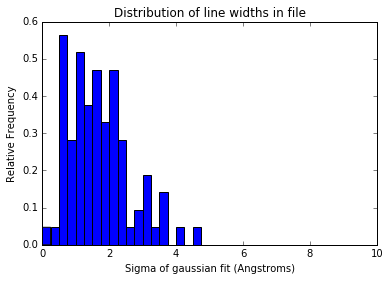

In [33]:
#Short code to find frequency of sigmas in a single file. 
allSigma = []
for temp in allObsFits:
    for line in temp:
        if not line[2] == -1:
            if not(line[2][1][0] < 0 and line[2][1][1] > 0):
                allSigma.append(line[0][0])
            
samp = plt.hist(allSigma, bins = 40, range =[0, 10], normed = True)
plt.xlabel("Sigma of gaussian fit (Angstroms)")
plt.ylabel("Relative Frequency")
plt.title("Distribution of line widths in file")
print samp
plt.show()

# Everything below here is debug purposes

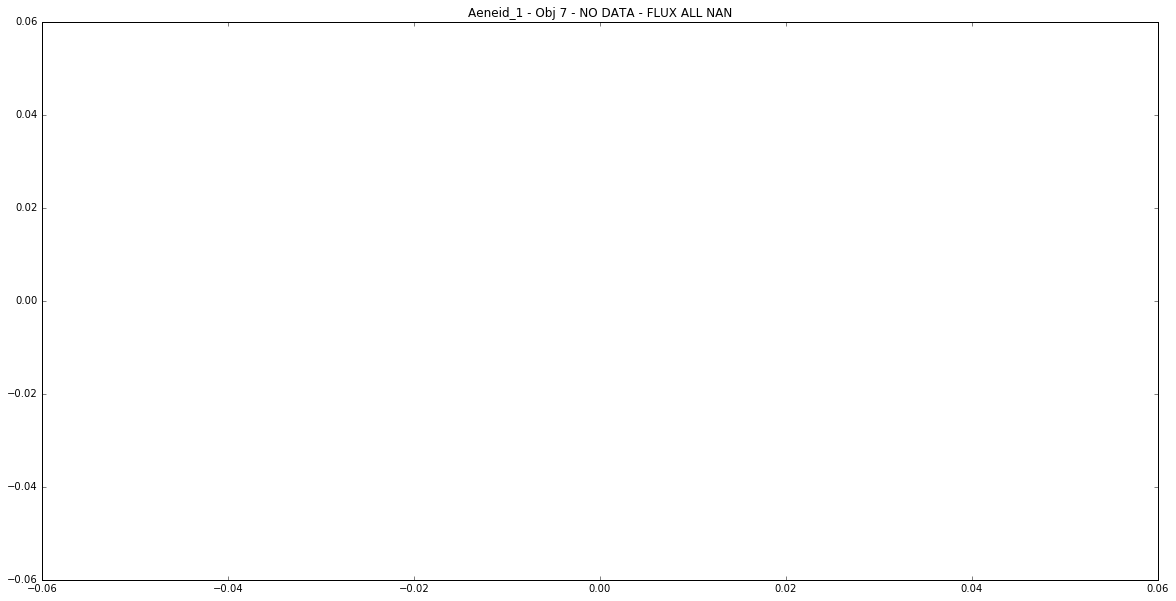

In [107]:
import itertools
test1 = fits.open(DATA_FOLDER + 'Aeneid_1.fits')
#test1.info()
#print wavelength

coord_val = test1[0].header['CRVAL1']
increment = test1[0].header['CDELT1']
coord_pix = test1[0].header['CRPIX1']
axis1_length = test1[0].header['NAXIS1']
start_val = coord_val - increment * coord_pix
end_val = start_val + increment * axis1_length 
wavelength = np.arange(start_val, end_val - increment, increment)


flux = test1[0].data[6]

plt.figure(figsize = (20, 10))
plt.title("Aeneid_1 - Obj 7 - NO DATA - FLUX ALL NAN")
plt.plot(wavelength, flux, '--')

#flux = test1[1].data[0]
#plt.plot(wavelength, flux, 'o')
plt.show()


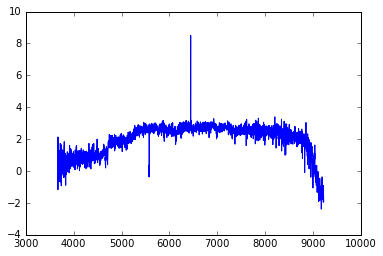

[0]

In [110]:
#t1 = time.time()
diagnosticsFits('2015.0918_1', 236, AAT = False)
#diagnosticsFits('Aeneid_1', 101, AAT = True)

#t2 = time.time()
#print t2 - t1

In [75]:
#This function is for printing out all of the diagnostics for a single object with a single file.
#It ought to print/save everything line by line
def diagnosticsFits(fitsNum, objNum, AAT = False):
    
    SHOW_PLOTS = False
    SAVE_PLOTS = True
    
    alpha = 0.05 #2 sigma, 95%
    
    
    if AAT:
        zlogFileName = fitsNum + ".zlog"
        fitsFileName = fitsNum + ".fits"
    else:
        zlogFileName = 'spHect-' + str(fitsNum) + ".zlog"
        fitsFileName = 'spHect-' + str(fitsNum) + ".fits"
    idName = str(fitsNum) + '_' + str(objNum + 1).zfill(3)
    diagnosticFile = DIAG_FOLDER + 'df' + str(idName) + '.dat'
    
    diagFile = open(diagnosticFile, 'w+')
    diagFile.write("Diagnostics for Object " + str(idName) + "\n")
    
    #try:
    #    zlogFile = open(zlogFileName, 'r')
    #except IOError:
    #    print "No file found with fitsNum %s" % fitsNum
        
    if AAT:
        fileData = AATDataClean(AATDataImport(fitsFileName, zlogFileName), objNum)
    else:
        fileData = MMTDataClean(MMTDataImport(fitsFileName, zlogFileName), objNum)

    wavelength = fileData[0]
    flux = fileData[1]
    sigma = fileData[2]
    zlog = fileData[3]
    
    plt.plot(wavelength, flux)
    plt.show()
          
    #Gets the shifted wavelengths that are still visible
    shiftLineInfo = getShiftLines(objNum, zlog)
    shiftedLines = shiftLineInfo[0]
    diagFile.write("Shifted Line Wavelengths: \n")
    diagFile.write(str(shiftedLines) + "\n")
    
    collectedFits = []
    
    #Step 3 - Loop through each of the lines
    if len(shiftedLines) == 1 and shiftedLines[0] == -1:
        print "No lines found in this file"
        diagFile.write("No lines found in this file")  
    else:
        for line in shiftedLines:
            if not line == -1:
                
                #Plots the region that the algorithm searches for the biggest dip in.
                lb = convertAngstromToBin(line - 50, wavelength)
                rb = convertAngstromToBin(line + 50, wavelength)
                plt.figure(figsize=(20,10))
                plt.errorbar(wavelength[lb:rb], flux[lb:rb], yerr = sigma[lb:rb], fmt = 'o')
                plt.title( "50 Angstrom Region around Predicted Line %s"%line )
                plt.xlabel( 'Wavelength')
                plt.ylabel("Flux")
                if SHOW_PLOTS:
                    plt.show()
                if SAVE_PLOTS:
                    plt.savefig(DIAG_FOLDER + "SearchRegion_" + str(idName) + "_Line_" + str(round(line)) + ".png")
                plt.clf()
                
                diagFile.write('\n')
                diagFile.write('Information for peak located at ' + str(round(line)) + ' angstroms as follows: \n')
                #Step 4, 5, 6 - get the code location for the peak near the identified line
                lineInfo = getPeak(objNum, [wavelength, flux, sigma], zlog, line)
                #Step 6.5: Check if the peak is missing or not. Append bad if needed. 
                if lineInfo[0] == -1:
                    diagFile.write("No peak found at line " + str(line))
                    collectedFits.append([[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]])
                else:
                    #Step 7: Get the range of data as needed
                    diagFile.write("Found following line info: \n" + str(lineInfo) + "\n")
                    lineData = getPeakInfo([wavelength, flux, sigma], lineInfo)
                    dof = len(lineData[0]) - 4
                    
                    #Step 8: Get the best theta fit
                    theta, covar = get_gauss_theta(lineData)
                    
                    if theta[0] == -1:
                        collectedFits.append([[-1, -1, -1, -1], -1, [[-1, 1], [-1, 1], [-1, 1], [-1, 1]]])
                        diagFile.write("Unable to find best fit to the Gaussian")
                    else:
                        diagFile.write("Found following theta parameters: \n " + str(theta) + "\n")
                        diagFile.write("Found following covariance matrix: \n " + str(covar) + "\n")
                        
                        #Step 9: Compute the reduced chi-squared value
                        chiSqRed = chiSquaredRed(lineData, theta, dof)
                        #Step 10: Compute the 95% confidence interval
                        CI = confInterval(theta, covar, alpha, dof)
                        #Step 11: Append to big list and repeat.
                        
                        diagFile.write("Found chiSquared-Reduced as: " + str(chiSqRed) + "\n")
                        diagFile.write("Found confidence intervals as follows: " + str(CI) + "\n")
                        collectedFits.append([theta, chiSqRed, CI])

                        xSpace = np.linspace(lineData[0][0] - 20, lineData[0][-1] + 20)
                        ySpace = gaussConst(xSpace, theta[0], theta[1], theta[2], theta[3])
                        plt.figure(figsize=(20,10))
                        realLB = convertAngstromToBin(lineData[0][0] - 20, wavelength)
                        realRB = convertAngstromToBin(lineData[0][-1] + 20, wavelength)
                        plt.errorbar(wavelength[realLB:realRB], flux[realLB:realRB], yerr = sigma[realLB:realRB], fmt = 'o', label = 'Region of peak fitting data')
                        #plt.errorbar(lineData[0], lineData[1], yerr = lineData[2], fmt = 'o', label = 'Region of peak fitting data')
                        plt.plot(xSpace, ySpace, '-', label = "Gaussian Fit")
                        plt.title("GaussianFit_" + str(idName) + "_line_" + str(round(line)))
                        plt.xlabel("Wavelength")
                        plt.ylabel("Flux")
                        plt.legend()
                        if SAVE_PLOTS:
                            plt.savefig(DIAG_FOLDER + "GaussianFit_" + str(idName) + "_line_" + str(round(line)) +  ".png")
                        if SHOW_PLOTS:
                            plt.show()
                        plt.clf()
                        
        diagFile.write("\n")
        diagFile.write("Summed Area:        " + str(easyClassification(collectedFits)) + "\n")
        diagFile.write("Integrated Area:    " + str(medClassification(collectedFits)) + "\n")
        diagFile.write("Med Classification: " + str(allClassified([collectedFits])) + "\n")
        #diagFile.write("Hard Classification:" + str(allClassified2(collectedFits)) + "\n")
                        
    diagFile.close()
                        
    return [0]


# More rudimentory debug functions follow below

In [86]:
#print allObsFits[13]
print medClassification(allObsFits[13])
#print getShiftLines(13, tr_zlog)

0


In [17]:
TRAIN_ZLOG = 'spHect-2015.0918_1.zlog'
TRAIN_FITS = 'spHect-2015.0918_1.fits'

train = fits.open(TRAIN_FITS)
f4 = open(TRAIN_ZLOG, 'r')
tr_zlog = f4.readlines()

tr_data0 = train[0].data #Wavelength - Angstrom
tr_data1 = train[1].data #Flux
tr_data2 = train[2].data #Inverse Variance!



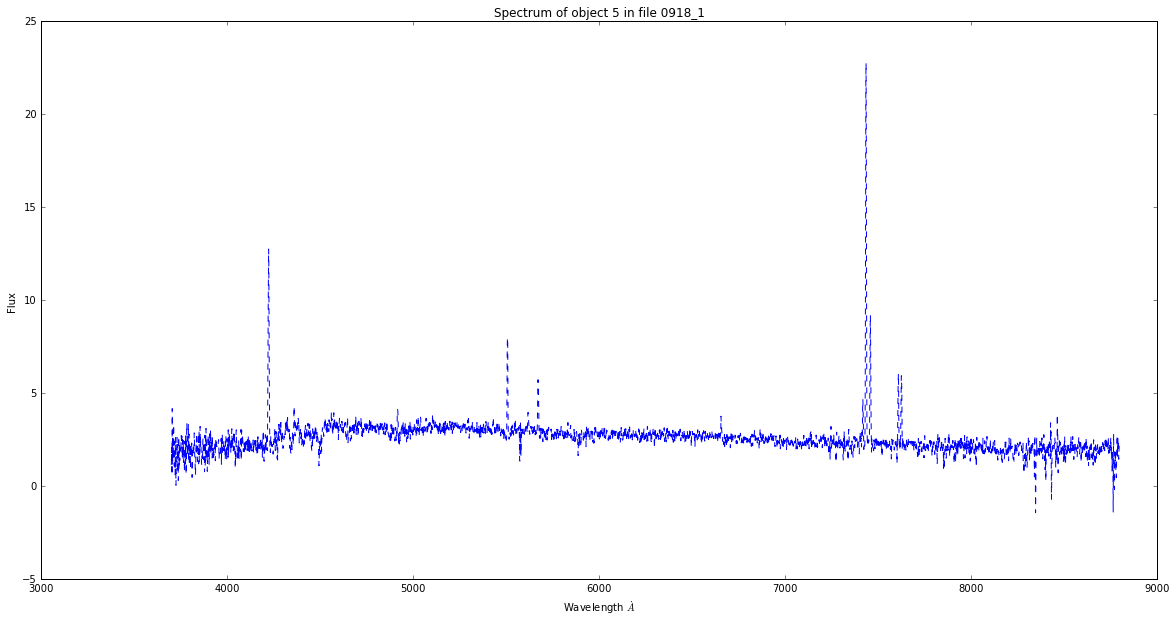

In [30]:

for i in range(len(tr_data2[TESTfileNum])):
    if tr_data2[TESTfileNum][i] == 0:
        tr_data2[TESTfileNum][i] = 1

tr_data2[TESTfileNum] = np.sqrt(1/tr_data2[TESTfileNum])

plt.figure(figsize = (20, 10))
#print len(tr_data0[TESTfileNum])

left = convertAngstromToBin(3700, tr_data0[TESTfileNum])
right = convertAngstromToBin(8800, tr_data0[TESTfileNum])

#left = convertAngstromToBin(5800, tr_data0)
#right = convertAngstromToBin(6100, tr_data0)

plt.plot(tr_data0[TESTfileNum][left:right], tr_data1[TESTfileNum][left:right], '--')
#plt.plot(tr_data0[1375:1390], tr_data1[1375:1390], 'o')
plt.xlabel("Wavelength $\dot{A}$")
plt.ylabel("Flux")
plt.title("Spectrum of object %s in file 0918_1"%(TESTfileNum+1))

plt.show()

In [76]:
def plotFit(fileNum, line, tr_data0, tr_data1, tr_data2):
    TRAIN_ZLOG = 'spHect-2015.0918_1.zlog'
    TRAIN_FITS = 'spHect-2015.0918_1.fits'

    train = fits.open(TRAIN_FITS)
    f4 = open(TRAIN_ZLOG, 'r')
    tr_zlog = f4.readlines()

    tr_data0 = train[0].data #Wavelength - Angstrom
    tr_data1 = train[1].data #Flux
    tr_data2 = train[2].data #Inverse Variance!
    
    for spectra in tr_data2:
        for i in np.where(spectra == 0)[0]:
            spectra[i] = 1
    
    alpha = 0.05 #For 95% Confidence Interval, ie 2 sigma
        
    data = [tr_data0[fileNum], tr_data1[fileNum], np.sqrt(1/tr_data2[fileNum])]
    
    #Plots the region that the algorithm searches for the biggest dip in.
    lb = convertAngstromToBin(line - 50, data[0])
    rb = convertAngstromToBin(line + 50, data[0])
    plt.errorbar(data[0][lb:rb], data[1][lb:rb], yerr = data[2][lb:rb], fmt = 'o')
    plt.title( "50 Angstrom Region around Predicted Line %s"%line )
    plt.xlabel( 'Wavelength')
    plt.ylabel("Flux")
    plt.show()
    plt.clf()
    
    #Actually do the searching
    lineInfo = getPeak(fileNum, data, tr_zlog, line)
    lineData = getPeakInfo(data, lineInfo)
    
    #Fit the gaussian, get the chi-squared and Confidence Interval
    dof = len(lineData[0]) - 4
    theta, covar = get_gauss_theta(lineData)
    chiSqRed = chiSquaredRed(lineData, theta, dof)
    CI = confInterval(theta, covar, alpha, dof)

    #Two checks: If no peaks were found (lineInfo[0] == -1) and if the covariance matrix is bad (CI[1][0] == -1)
    if lineInfo[0] == -1:
        print "No peak found; no fit made"
    else:
        if CI[1][0] == -1:
            print "Bad covariance matrix; no results"
        else:
            print "Best fit of A:                          " + str(theta[1])
            print "95% (2 sigma) Confidence Interval on A: " + str(CI[1])
            
            if (CI[1][0] < 0 and CI[1][1] > 0):
                print "Confidence Interval outside of range; predicted bad fit (fit disregarded)"
                
            print "Ratio of sigma to A:                    " + str(np.abs((CI[1][0] - theta[1]) / (2 * theta[1])))
            xSpace = np.linspace(lineData[0][0], lineData[0][-1])
            fittedVals = gaussConst(xSpace, theta[0], theta[1], theta[2], theta[3])
            plt.title("Fitting region overplotted with best fit")
            plt.xlabel("Wavelength [Angstrom]")
            plt.ylabel("Flux")

            plt.errorbar(lineData[0], lineData[1], yerr = lineData[2], fmt = 'o')
            plt.plot(xSpace, fittedVals)
    


Amplitude of fits
[-1, 34.565059304360318, -0.60802800668363699, -1.1220210208695101, 2.5260048742298702, -2.2283900460457642]
Shifted lines for this obj
[4887.45963321, 5161.27846946, 6378.42451183, 6504.650076440001, 6786.94253991, 7728.02672706]


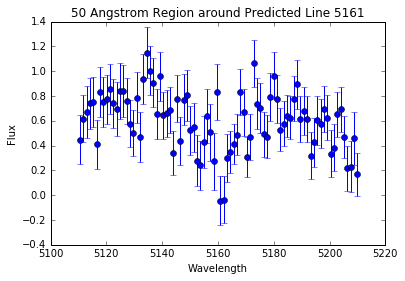

Best fit of A:                          34.5650593044
95% (2 sigma) Confidence Interval on A: [-9430.2066661473291, 9499.3367847560512]
Confidence Interval outside of range; predicted bad fit (fit disregarded)
Ratio of sigma to A:                    136.912418435


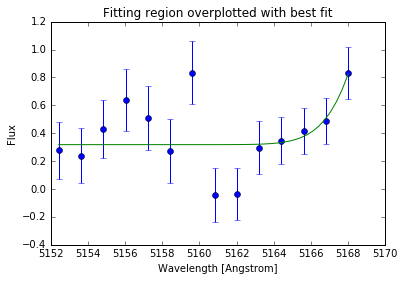

In [88]:
TESTfileNum = 13#CHANGE THIS WHENEVER YOU WANT TO TEST A NEW FILE
a = fitPeakDips(TESTfileNum, tr_data0[TESTfileNum], tr_data1[TESTfileNum], tr_data2[TESTfileNum], tr_zlog)
#print a
print "Amplitude of fits"
print [row[0][1]for row in a]

print "Shifted lines for this obj"
print getShiftLines(TESTfileNum, tr_zlog)
plotFit(TESTfileNum, 5161, tr_data0, tr_data1, tr_data2)

#print [row[2][0] for row in a]
#print a[0][2][1] #This gives you the range of A in parameter fitting by 95% confidence level.
#I think we can use this - if the range is too large for A(ie, negative and positive), then throw out the line - say that there does not exist anything
#If it is less than something... more than something... use sigma? unclear.
#Then do a weighted majority vote based on A. Or just add up all of the As.

# Current todo:
1) Fix the gaussian algorithm for dips. Seems to work for spikes! Very promising - just something in the algorithm - <b>Solved!</b> Remaining problem - 100 Angstrom might be too large of a region to search. Narrow down to 15 angstrom for now.

2) Let Geha know about current progress, have working reduced chi-squared, fits include uncertainty in data, calculated <b>Solved!</b>

3) Using training set, see if there are patterns in the parameter space. Graph them or something <b> No longer needed! </b>

4) Create a better CI code through using bootstrap and chi squared, although also clarify w/ Geha before moving forwards <b> Unclear if still needed?</b>

5) Write production code for auto classification <b> Solved! </b>

6) Implement smoothing code!!! <b> Uncertain on implementation? </b>

.


<font size="+2">Known Issues:</font>
 
Breaks when there is really poorly selected data, or when there does not exist data - <b> Solved, using try/except blocks </b>

Does not work well when there is poorly smoothed data - <b> NEED HELP - Unclear on how to properly smooth the sigma data? </b>

Sometimes, fit will return a negative sigma and a negative A. <b> Unclear on solution? </b>

Possibly not working well with different line widths - currently assumes a 10 pixel region. 